In [9]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory

# === Step 1: Load dataset ===
train_ds = image_dataset_from_directory(
    "dataset/",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(256, 256),
    batch_size=32
)

val_ds = image_dataset_from_directory(
    "dataset/",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(256, 256),
    batch_size=32
)

class_names = train_ds.class_names
print("Class names:", class_names)

# === Step 2: Define augmentation and normalization ===
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2),
])

normalization_layer = tf.keras.layers.Rescaling(1./255)

# === Step 3: Apply preprocessing to datasets ===

# Train: augmentation + normalization
train_ds = train_ds.map(lambda x, y: (normalization_layer(data_augmentation(x, training=True)), y))

# Val: only normalization
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))


Found 16500 files belonging to 3 classes.
Using 13200 files for training.
Found 16500 files belonging to 3 classes.
Using 3300 files for validation.
Class names: ['Cape Sparrow', 'Masked Weaver', 'Squirrel']


In [10]:
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model = models.Sequential([
    layers.Input(shape=(256, 256, 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.4),
    layers.Dense(3, activation='softmax')  # 3 output classes
])

In [11]:
model.compile(
    optimizer='adam',
    loss=SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,234,499 (50.49 MB)

 Trainable params: 13,234,499 (50.49 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [13]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    callbacks=[early_stop]
)

Epoch 1/40
413/413 ━━━━━━━━━━━━━━━━━━━━ 982s 2s/step - accuracy: 0.5203 - loss: 1.1237 - val_accuracy: 0.7515 - val_loss: 0.6492
Epoch 2/40
413/413 ━━━━━━━━━━━━━━━━━━━━ 915s 2s/step - accuracy: 0.7435 - loss: 0.6930 - val_accuracy: 0.7652 - val_loss: 0.6446
Epoch 3/40
413/413 ━━━━━━━━━━━━━━━━━━━━ 887s 2s/step - accuracy: 0.7710 - loss: 0.6515 - val_accuracy: 0.7812 - val_loss: 0.6324
Epoch 4/40
413/413 ━━━━━━━━━━━━━━━━━━━━ 878s 2s/step - accuracy: 0.7847 - loss: 0.6160 - val_accuracy: 0.8109 - val_loss: 0.5393
Epoch 5/40
413/413 ━━━━━━━━━━━━━━━━━━━━ 860s 2s/step - accuracy: 0.7971 - loss: 0.5893 - val_accuracy: 0.8070 - val_loss: 0.5359
Epoch 6/40
413/413 ━━━━━━━━━━━━━━━━━━━━ 860s 2s/step - accuracy: 0.8115 - loss: 0.5616 - val_accuracy: 0.8336 - val_loss: 0.4920
Epoch 7/40
413/413 ━━━━━━━━━━━━━━━━━━━━ 860s 2s/step - accuracy: 0.8247 - loss: 0.5343 - val_accuracy: 0.8258 - val_loss: 0.5303
Epoch 8/40
413/413 ━━━━━━━━━━━━━━━━━━━━ 862s 2s/step - accuracy: 0.8264 - loss: 0.5214 - val_accu

In [14]:
model.save("3_Species_cnn_2025_07_19.keras")

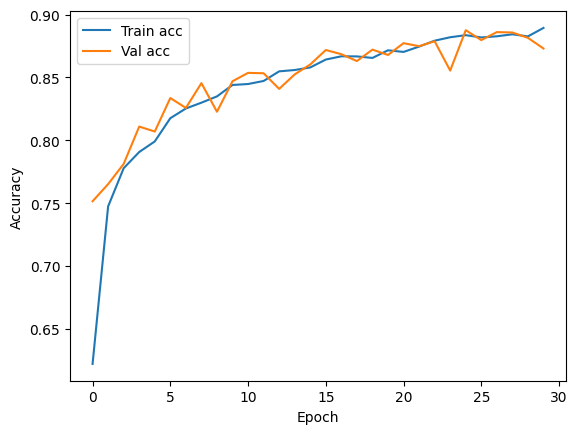

In [15]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()